### OpenCV + YOLOv4 for Object Detection IMG###

In [50]:
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt

### Setup Functions ###

In [51]:
def img_show(img, size=(10,7)):
    # Display img from cv2 format func:
    fig = plt.gcf()
    fig.set_size_inches(size)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [52]:
def Config_Net(net_weights_path, net_config_path):
    # Config net using cv2 (needs weights and config files)
    net = cv2.dnn.readNet(net_config_path, net_weights_path)
    output_layers = net.getLayerNames()
    output_layers  = [output_layers [i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return net, output_layers 

In [53]:
def YOLO_Processing(img, net, output_layers):
    # Pass img/frame, net and output layers get output:

    start= time.time()

    # Modify img to input format:
    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB = True, crop = False)

    # Pass to net:
    net.setInput(blob)
    layer_outputs = net.forward(output_layers)

    end = time.time()
    
    yolo_process_time = end - start
    
    return layer_outputs, yolo_process_time

In [62]:
def YOLO_Detections(img, net, output_layers, labels, colors, threshold = 0.5, threshold_NMS = 0.3):
    # Output format:
    # (pc, bx, by, bh, bw, .... class_preds)
    
    # Make img copy for later use:
    img_cp = img.copy()

    (H, W) = img.shape[:2]
    
    layer_outputs, yolo_process_time = YOLO_Processing(img, net, output_layers)
    
    boxes = []
    confiability = []
    IDclasses = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            classeID = np.argmax(scores) # Get class with more probability
            trust = scores[classeID]
            if trust > threshold:
                # reescale poistion values:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype('int')

                # box strcuture:
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confiability.append(float(trust))
                IDclasses.append(classeID)
    
    # Filtering detected object boxes with NMS (Non-maxima Suppression):
    objs = cv2.dnn.NMSBoxes(boxes, confiability, threshold, threshold_NMS)
    
    # Draw Desired Boxes:
    if len(objs) > 0:
        for i in objs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in colors[IDclasses[i]]]

            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(labels[IDclasses[i]], confiability[i])
            cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img, boxes, confiability, yolo_process_time

### Object Detection and Classification Example ###

In [55]:
# Get Yolo Net Architecture Weights and Configuration:
net_weights_path = 'YOLO/YOLO/yolov4.weights'
net_config_path = 'YOLO/YOLO/cfg/yolov4.cfg'
net, output_layers = Config_Net(net_weights_path, net_config_path)

In [56]:
# Check structure:
print('Total of Layers: ' + str(len(output_layers)))
print(output_layers)

Total of Layers: 3
['yolo_139', 'yolo_150', 'yolo_161']


In [57]:
# Get coco class labels:
coco_labels = open('YOLO/YOLO/cfg/coco.names').read().strip().split('\n')
print(coco_labels)
print(len(coco_labels))

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
80


In [58]:
# Generate random colors for bboxes:
np.random.seed(0)
colors = np.random.randint(0, 255, size=(len(coco_labels), 3), dtype='uint8')

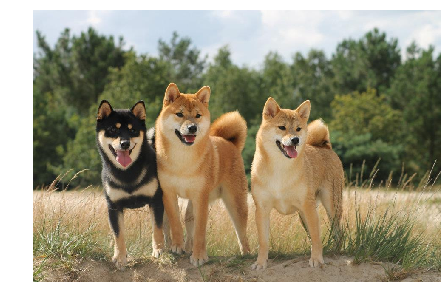

In [59]:
# Check test img:
img = cv2.imread('YOLO/YOLO/imagens/cachorros.jpg')
img_show(img, size=(8,5))

In [60]:
# Define necessary variables:
threshold = 0.5
threshold_NMS = 0.3

YOLO process time: 1.5993380546569824


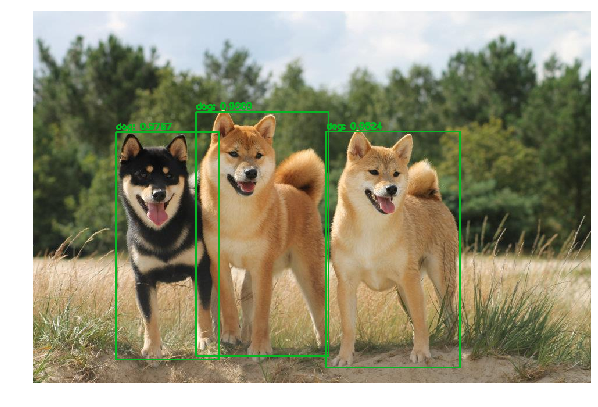

In [61]:
img, boxes, confiability, yolo_process_time = YOLO_Detections(img, net, output_layers, coco_labels, colors, threshold, threshold_NMS)

print('YOLO process time:', yolo_process_time)

img_show(img, size=(10,7))